# 🔁 Day 12: Transfer Learning with Pretrained CNNs

In this notebook, we'll use **Transfer Learning** with a **pretrained ResNet50** model to classify images from a subset of CIFAR-10.

### Goals:
- Load and preprocess CIFAR-10 dataset
- Use ResNet50 with pretrained ImageNet weights
- Train only the top layers on CIFAR-10
- Evaluate and visualize the results

In [11]:
# ✅ Imports
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

In [12]:
# ✅ Download & extract Cats vs Dogs filtered dataset
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_path = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=url, extract=True)
base_dir = os.path.join(os.path.dirname(zip_path), 'cats_and_dogs_filtered')

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')


In [14]:
# ✅ Unzip the dataset
import zipfile
import os

zip_path = "/content/cats_and_dogs_filtered.zip"
extract_path = "/content/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# ✅ Set directory paths
base_dir = os.path.join(extract_path, "cats_and_dogs_filtered")
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")

# ✅ Data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 160
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(train_dir,
                                        target_size=(IMG_SIZE, IMG_SIZE),
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(val_dir,
                                      target_size=(IMG_SIZE, IMG_SIZE),
                                      batch_size=BATCH_SIZE,
                                      class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
# ✅ Load pretrained ResNet50 base (no top layer)
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze the convolutional base

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
# ✅ Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [17]:
# ✅ Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# ✅ Train the model
history = model.fit(train_gen,
                    epochs=3,
                    validation_data=val_gen)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 256ms/step - accuracy: 0.5003 - loss: 0.7114 - val_accuracy: 0.5000 - val_loss: 0.6847
Epoch 2/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.5692 - loss: 0.6730 - val_accuracy: 0.5720 - val_loss: 0.6723
Epoch 3/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.5932 - loss: 0.6635 - val_accuracy: 0.5890 - val_loss: 0.6637


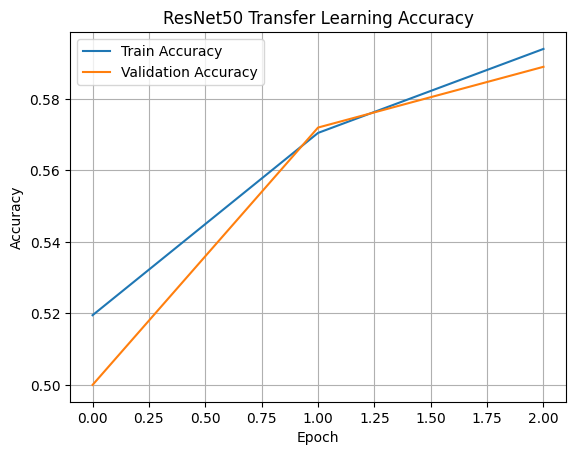

In [18]:
# ✅ Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("ResNet50 Transfer Learning Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()